In [1]:
%%HTML
<style type="text/css">

div.h2 {
    background-color: steelblue; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 20px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}
div.h3 {
    color: steelblue; 
    font-size: 14px; 
    margin-top: 20px; 
    margin-bottom:4px;
}
div.h4 {
    font-size: 15px; 
    margin-top: 20px; 
    margin-bottom: 8px;
}
span.note {
    font-size: 5; 
    color: gray; 
    font-style: italic;
}
span.captiona {
    font-size: 5; 
    color: dimgray; 
    font-style: italic;
    margin-left: 130px;
    vertical-align: top;
}
hr {
    display: block; 
    color: gray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}
hr.light {
    display: block; 
    color: lightgray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;
}
table.dataframe th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
}
table.dataframe td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
    text-align: center;
} 
table.rules th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 14px;
}
table.rules td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 13px;
    text-align: center;
} 
table.rules tr.best
{
    color: green;
}

</style>

In [35]:
# !pip install torchsummary
# from torchsummary import summary
# Core
import pandas as pd
import numpy as np
import gc
import math
# Data Visualization
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
# PyTorch 
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# Transformers 
from transformers import AutoConfig, AutoModel, AutoTokenizer
# Catalyst
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, F1ScoreCallback, OptimizerCallback
from catalyst.dl.callbacks import CheckpointCallback, InferCallback
from catalyst.utils import set_global_seed, prepare_cudnn
# Extras
import warnings
warnings.filterwarnings('ignore')
import os
import logging
from typing import Mapping, List
import datetime as dt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from IPython.display import HTML, Image
# Better Reports
pd.set_option("display.max_columns", 100)
th_props = [('font-size', '13px'), ('background-color', 'white'), 
            ('color', '#666666')]
td_props = [('font-size', '15px'), ('background-color', 'white')]
styles = [dict(selector="td", props=td_props), dict(selector="th", 
            props=th_props)]
# Plots visualization improvement
%config InlineBackend.figure_format = 'retina'

# specify GPU
device = torch.device("cuda")

In [3]:
# It's a good practice to save on a plain text the modules and its versions
# It's help others when running your experiments
!pip freeze > requirements.txt

In [36]:
data_path = "/kaggle/input/news-category-dataset/"
data = pd.read_json(data_path+"News_Category_Dataset_v3.json", lines=True)

In [37]:
# MODEL_NAME = "distilbert-base-uncased"
MODEL_NAME = "gpt2"
LOG_DIR = "./news-classification"    
NUM_EPOCHS = 3                         
BATCH_SIZE = 80
TEST_BATCH_SIZE = 1000
MAX_SEQ_LENGTH = 256                   
LEARN_RATE = 0.01                     
ACCUM_STEPS = 4                        
SEED = 42                              
FP16_PARAMS = None

In [30]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
rm -rf ./apex

Overwriting setup.sh


In [7]:
%%capture
!sh setup.sh
FP16_PARAMS = dict(opt_level="O1") 

In [38]:
categories = data['category'].unique()
## Consolidate some of the groups to Mitigate class imbalance
def groupper(dataset, grouplist, name):
    for ele in categories:
        if ele in grouplist:
            dataset.loc[dataset['category'] == ele, 'category'] = name

## Sample the data for experiment fewer data
def sampler(data):
    unique_category = data['category'].unique()
    sampled_data = pd.DataFrame()
    for category in unique_category: 
        n = data.loc[data['category'] == category].shape[0]
        sampled_data = pd.concat([sampled_data, data.loc[data['category'] == category, :].sample(min(n, 8000), random_state=1213)], axis=0)
    
    sampled_data.reset_index(inplace=True, drop=True)
    return sampled_data

In [39]:
data['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64

In [40]:
groupper( dataset = data, grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')
groupper( dataset = data, grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')
groupper( dataset = data, grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')
groupper( dataset = data, grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')
groupper( dataset = data, grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')
groupper( dataset = data, grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')
groupper( dataset = data, grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')
groupper( dataset = data, grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')
groupper( dataset = data, grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')
groupper( dataset = data, grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')
groupper( dataset = data, grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')


In [41]:
data['category'].value_counts()

LIFESTYLE AND WELLNESS          41027
POLITICS                        35602
SPORTS AND ENTERTAINMENT        32125
TRAVEL-TOURISM & ART-CULTURE    20749
EMPOWERED VOICES                15632
PARENTING AND EDUCATION         14904
MISC                            12600
GENERAL                          9845
WORLDNEWS                        9542
BUSINESS-MONEY                   7748
SCIENCE AND TECH                 4310
ENVIRONMENT                      4066
U.S. NEWS                        1377
Name: category, dtype: int64

In [42]:
data = sampler(data)
data['category'].value_counts()

PARENTING AND EDUCATION         8000
MISC                            8000
SPORTS AND ENTERTAINMENT        8000
GENERAL                         8000
POLITICS                        8000
EMPOWERED VOICES                8000
WORLDNEWS                       8000
LIFESTYLE AND WELLNESS          8000
TRAVEL-TOURISM & ART-CULTURE    8000
BUSINESS-MONEY                  7748
SCIENCE AND TECH                4310
ENVIRONMENT                     4066
U.S. NEWS                       1377
Name: category, dtype: int64

In [43]:
text = pd.DataFrame({
    "text" : data.headline+" "+data.short_description,
    "label" : data.category  
})

train, val = train_test_split(
    text, test_size=0.30, random_state=SEED)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

val, test = train_test_split(
    val, test_size=0.10, random_state=SEED)

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

test_true = pd.DataFrame({
    "label" : test.label
})

# test.drop(columns=["label"], axis=1, inplace=True)

print(train.shape)
print(val.shape)
print(test.shape)


(62650, 2)
(24165, 2)
(2686, 2)


PyTorch uses a specific input called tensors, all the dataset needs to be converted to tensors.<br>
It's needed to create a class to convert to tensors and after load every set (Train, Validation and Test).

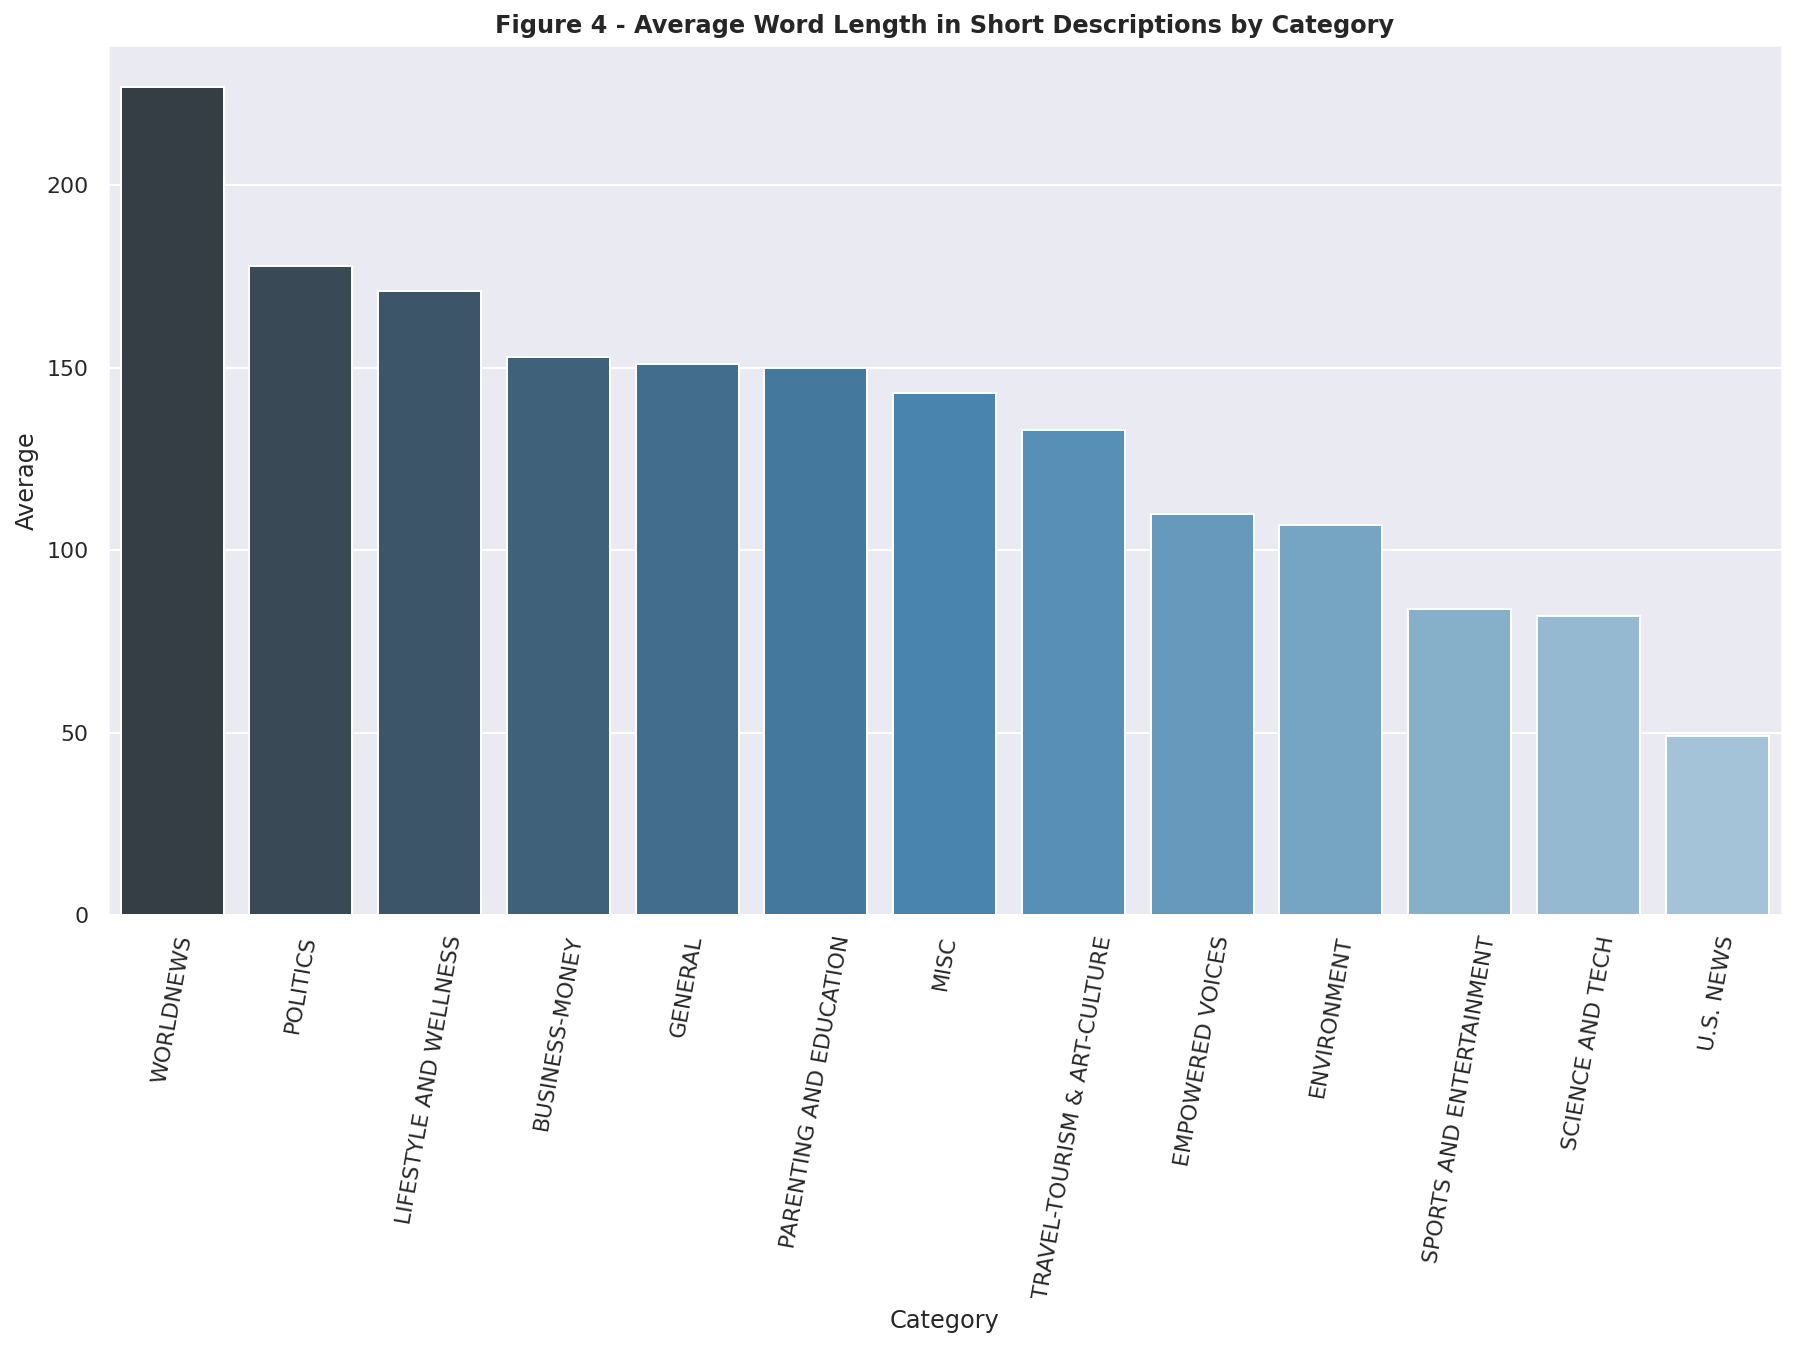

In [44]:
categories = train["label"].unique()
aux = []
j = 0
for i in categories:
    df_aux = train[train["label"] == i]
    aux.append(np.max(df_aux['text'].apply(lambda x : len(x.split()))))
    j = j+1

df_aux = pd.DataFrame({
    "Category" : categories,
    "Average": aux
}
)

df_aux = df_aux.sort_values(['Average'], ascending=False).reset_index(drop=True)

sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(x="Category", y="Average", data=df_aux, palette="Blues_d")
plt.title("Figure 4 - Average Word Length in Short Descriptions by Category",
          fontweight="bold", size=12)
plt.xticks(rotation=80);

In [45]:
class TextClassificationDataset(Dataset):

    def __init__(self,
                 texts: List[str],
                 labels: List[str] = None,
                 label_dict: Mapping[str, int] = None,
                 max_seq_length: int = 512,
                 model_name: str = 'distilbert-base-uncased'):

        self.texts = texts
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            self.label_dict = dict(zip(sorted(set(labels)),
                                       range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        logging.getLogger(
            "transformers.tokenization_utils").setLevel(logging.FATAL)

#         self.sep_vid = self.tokenizer.vocab["[SEP]"]
#         self.cls_vid = self.tokenizer.vocab["[CLS]"]
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.pad_vid = self.tokenizer.pad_token

    def __len__(self):

        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:

        x = self.texts[index]
        x_encoded = self.tokenizer.encode(
            x,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
        ).squeeze(0)

        true_seq_length = x_encoded.size(0)
        pad_size = self.max_seq_length - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        x_tensor = torch.cat((x_encoded, pad_ids))

        mask = torch.ones_like(x_encoded, dtype=torch.int8)
        mask_pad = torch.zeros_like(pad_ids, dtype=torch.int8)
        mask = torch.cat((mask, mask_pad))

        output_dict = {
            "features": x_tensor,
            'attention_mask': mask
        }

        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor(
                [self.label_dict.get(y, -1)]
            ).long().squeeze(0)
            output_dict["targets"] = y_encoded

        return output_dict

In [46]:
train_dataset = TextClassificationDataset(
    texts=train['text'].values.tolist(),
    labels=train['label'].values.tolist(),
    label_dict=None,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

valid_dataset = TextClassificationDataset(
    texts=val['text'].values.tolist(),
    labels=val['label'].values.tolist(),
    label_dict=train_dataset.label_dict,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

test_dataset = TextClassificationDataset(
    texts=test['text'].values.tolist(),
    labels=test['label'].values.tolist(),
    label_dict=train_dataset.label_dict,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

And define the number of classes of the output feature based on the train set.

In [47]:
NUM_CLASSES = len(train_dataset.label_dict)
print(NUM_CLASSES)

13


When working with PyTorch, the sets need to be loaded in dictionaries.

In [48]:
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)    
}

test_loaders = {
    "test": DataLoader(dataset=test_dataset,
                        batch_size=TEST_BATCH_SIZE, 
                        shuffle=False) 
}

In [49]:
len(train_val_loaders['train'])

784

A class defines the model with its forward pass.

In [50]:
class DistilBertForSequenceClassification(nn.Module):

    def __init__(self, pretrained_model_name: str, num_classes: int = None):

        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name,
                                                    config=config)
        ## freeze all the parameters
        for param in self.distilbert.parameters():
            param.requires_grad = False 
            
        self.pre_classifier = nn.Linear(config.n_embd, config.n_embd)
        self.classifier = nn.Linear(config.n_embd, num_classes)
        self.dropout = nn.Dropout(config.attn_pdrop)


    def forward(self, features, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "attention mask is none"
        distilbert_output = self.distilbert(input_ids=features,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)
#         print(distilbert_output[0])

        hidden_state = distilbert_output[0]  
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)  
        pooled_output = nn.ReLU()(pooled_output)  
        pooled_output = self.dropout(pooled_output)  
        logits = self.classifier(pooled_output)  

        return F.log_softmax(logits, dim=1)

Finally, the load the model with the criterion, optimizer and learning rate scheduler.<br>
And setting the GPU devices to use and Random Seed.

In [51]:
model = DistilBertForSequenceClassification(pretrained_model_name=MODEL_NAME,
                                            num_classes=NUM_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
# summary(model)
# push the model to GPU
model = model.to(device)

In [52]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"   
set_global_seed(SEED)                       
prepare_cudnn(deterministic=True)           

The model training starts now with Catalyst doing a good amount of work.

In [53]:
def train_model(model, epoch, train_loader, optimizer, log_interval, train_losses, train_counter): 
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch.values()]

        # get features attentnion mask and label from the next batch 
        features, attention_mask, label = batch 
        
        # clear gradient from the previous step
        optimizer.zero_grad()
        
        # get model predictions for the current batch 
        output = model(features, attention_mask)
        
        # compute loss between prediction and ground truth 
        loss = F.nll_loss(output, label)
        
        # aggregate total loss 
        total_loss = total_loss + loss.item()
        
        # backpropagate to calculate the gradient. 
        loss.backward()

        # clip the gradients to 1.0, so that it doesn't explode the gradient 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update the parameters 
        optimizer.step()
        
        # move prediction from GPU to CPU.
        output=output.detach().cpu().numpy()
        if batch_idx % log_interval == 0: 
            # print training progress
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*BATCH_SIZE) + ((epoch-1)*len(train_loader.dataset)))
    
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss

In [54]:
def test_model(model, test_loader, test_losses): 
    model.eval()
    total_loss = 0
    correct = 0
    for batch_idx, batch in enumerate(test_loader):
        # push the batch to gpu
        batch = [t.to(device) for t in batch.values()]
        # get features attentnion mask and label from the next batch 
        features, attention_mask, label = batch 
        # stop grads for testing 
        with torch.no_grad():   
            output = model(features, attention_mask)
            test_loss = F.nll_loss(output, label, size_average=False).item() 
            total_loss = total_loss + test_loss
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(label.view_as(pred)).sum()
        test_losses.append(test_loss)
#         if batch_idx % log_interval == 0: 
    avg_loss = total_loss / len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))
    return avg_loss


In [55]:
# torch.cuda.empty_cache()
# del model, batch, output, loss, output, 
# gc.collect()

train_losses = []
train_counter = []

valid_losses = []
valid_counter = [i*len(train_val_loaders['valid'].dataset) for i in range(NUM_EPOCHS + 1)]

log_interval = math.floor(len(train_val_loaders['train']) / 100)

for epoch in range(1, NUM_EPOCHS + 1): 
    train_loss = train_model(model, epoch, train_val_loaders['train'], optimizer, 8, train_losses, train_counter)
    test_loss = test_model(model, train_val_loaders['valid'], valid_losses)

Train Epoch: 1 [0/62650 (0%)]	Loss: 3.352196
Train Epoch: 1 [640/62650 (1%)]	Loss: 3.317809
Train Epoch: 1 [1280/62650 (2%)]	Loss: 2.491632
Train Epoch: 1 [1920/62650 (3%)]	Loss: 2.481412
Train Epoch: 1 [2560/62650 (4%)]	Loss: 2.482374
Train Epoch: 1 [3200/62650 (5%)]	Loss: 2.466358
Train Epoch: 1 [3840/62650 (6%)]	Loss: 2.477805
Train Epoch: 1 [4480/62650 (7%)]	Loss: 2.498381
Train Epoch: 1 [5120/62650 (8%)]	Loss: 2.581519
Train Epoch: 1 [5760/62650 (9%)]	Loss: 2.472343
Train Epoch: 1 [6400/62650 (10%)]	Loss: 2.469944
Train Epoch: 1 [7040/62650 (11%)]	Loss: 2.501040
Train Epoch: 1 [7680/62650 (12%)]	Loss: 2.564464
Train Epoch: 1 [8320/62650 (13%)]	Loss: 2.471760
Train Epoch: 1 [8960/62650 (14%)]	Loss: 2.514589
Train Epoch: 1 [9600/62650 (15%)]	Loss: 2.494290
Train Epoch: 1 [10240/62650 (16%)]	Loss: 2.566229
Train Epoch: 1 [10880/62650 (17%)]	Loss: 2.522883
Train Epoch: 1 [11520/62650 (18%)]	Loss: 2.571985
Train Epoch: 1 [12160/62650 (19%)]	Loss: 2.479161
Train Epoch: 1 [12800/62650 (2

In [70]:
# del batch
# del output
# del test_loss
# del train_loss
# torch.cuda.empty_cache()
# gc.collect()
from sys import getsizeof
getsizeof(model)

56

In [73]:
# get predictions for test data
predictions = []
true_y = []
torch.cuda.empty_cache()
gc.collect()

with torch.no_grad():
    for test_batch_idx, batch in enumerate(test_loaders['test']):
        batch = [t.to(device) for t in batch.values()]
        features, attention_mask, label = batch 
        true_y = np.concatenate([true_y, label.detach().cpu().numpy()])
        preds = model(features, attention_mask)
        preds = preds.detach().cpu().numpy()
        predictions = np.concatenate([predictions, np.argmax(preds, axis = 1)])


RuntimeError: CUDA out of memory. Tried to allocate 2.93 GiB (GPU 0; 15.90 GiB total capacity; 12.24 GiB already allocated; 2.49 GiB free; 12.68 GiB reserved in total by PyTorch)

In [71]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=27a204bff046c9a600b85320852cd4600339621ffd9f96bcb99b580482af5dad
  Stored in directory: /root/.cache/pip/wheels/79/c1/b2/b6fc2647f693a084da25e1d31328ab3dbb565cc58fea37e973
Successfully built GPUtil
| ID | GPU | MEM |
------------------


In [72]:
gpu_usage()                             


| ID | GPU | MEM |
------------------


In [ ]:
test_pred = pd.DataFrame(
    {
        "label": predictions
    }
)
test_true = pd.DataFrame(
    {
        "label": true_y
    }
)
test_pred["label"] = test_pred["label"].map({v:k for k, v in train_dataset.label_dict.items()})
test_true["label"] = test_true["label"].map({v:k for k, v in train_dataset.label_dict.items()})

unique_label = train["label"].unique()
cmtx = pd.DataFrame(
    confusion_matrix(test_true, test_pred, labels=unique_label), 
    index=['{:}'.format(x) for x in unique_label], 
    columns=['{:}'.format(x) for x in unique_label]
)

plt.figure(figsize=(25, 15))
ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu", linecolor="grey", linewidths=.3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Target');
ax.set_title("Figure 9 - Test Set Confusion Matrix", size=12)

acc = accuracy_score(test_true, test_pred)
prec = precision_score(test_true, test_pred, average="weighted")
f1 = f1_score(test_true, test_pred, average="weighted")
print(f"Test Accuracy: {acc}")
print(f"Test Precision: {prec}")
print(f"Test F1 Score: {f1}");

To finish it, let's make an inference on Test Set to predict the results later.

<a id='re'></a>
<div class="h2">Results</div>
<br>
With the Inference made on the Test Set, let's predict the probabilities of classes for each samples and get class with the high probability and save as the prediction.<br>
The Results for the accuracy, precision and F1 Score for the Test Set are given followed by the Confusion Matrix on The Figure 9.

In [ ]:
predicted_probs = runner.state.callbacks[0].predictions['logits']
test_pred = pd.DataFrame(
    {
        "label": predicted_probs.argmax(axis=1)
    }
)
test_pred["label"] = test_pred["label"].map({v:k for k, v in train_dataset.label_dict.items()})

unique_label = train["label"].unique()
cmtx = pd.DataFrame(
    confusion_matrix(test_true, test_pred, labels=unique_label), 
    index=['{:}'.format(x) for x in unique_label], 
    columns=['{:}'.format(x) for x in unique_label]
)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
ax.set_ylabel('Predicted')
ax.set_xlabel('Target');
ax.set_title("Figure 9 - Test Set Confusion Matrix", size=12)

acc = accuracy_score(test_true, test_pred)
prec = precision_score(test_true, test_pred, average="weighted")
f1 = f1_score(test_true, test_pred, average="weighted")
print(f"Test Accuracy: {acc}")
print(f"Test Precision: {prec}")
print(f"Test F1 Score: {f1}");

<a id='end'></a>
<div class="h2">Conclusion</div>
<br>
On the EDA, was shwon that HuffPost changed a lot its content from the year, from a website with many posts about wellness to a site with opinions and news about politics.<br> 
As seen by the results, the three metrics got a good score (above 0.7) and the matrix confusion revealed a few samples with wrong classification.<br> DistilBERT showed how can it be powerful for NLP.<br>